In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv
class DNAGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(DNAGCN, self).__init__()
        # Graph convolutional layers
        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(GCNConv(input_dim, hidden_dim))
        for _ in range(num_layers - 2):
            self.conv_layers.append(GCNConv(hidden_dim, hidden_dim))
        self.conv_layers.append(GCNConv(hidden_dim, output_dim))
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # Apply graph convolutional layers
        for conv_layer in self.conv_layers:
            x = F.relu(conv_layer(x, edge_index))
        return x
# Example usage:
# Create a random DNA sequence bond matrix (adjacency matrix)
# For simplicity, assume a sequence length of 10
input_dim = 4  # For example, if DNA sequences are represented using one-hot encoding
hidden_dim = 64
output_dim = 128
num_layers = 3

sequence_length = 10
adjacency_matrix = torch.rand((sequence_length, sequence_length))
# Convert the adjacency matrix to edge indices
edges = torch.nonzero(adjacency_matrix, as_tuple=True)
# Create a simple data object with ‘x’ as node features and ‘edge_index’ as edge indices
data = torch_geometric.data.Data(x=torch.randn(sequence_length, input_dim), edge_index=edges)
# Instantiate and forward pass through the DNAGCN model

model = DNAGCN(input_dim, hidden_dim, output_dim, num_layers)
output = model(data)

In [1]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
Data(edge_index=[2, 4], x=[3, 1])

Data(x=[2], edge_index=[2])

In [1]:
from aptamer_transformer.model import *
from aptamer_transformer.factories_model_loss import *
from aptamer_transformer.data_utils import *
import matplotlib.pyplot as plt

cfg = read_cfg('../aptamer_transformer/config.yaml')
df = load_df(cfg)

2024-01-25 19:50:48.935958: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-25 19:50:48.977083: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 19:50:48.977122: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 19:50:48.978416: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-25 19:50:48.986432: I tensorflow/core/platform/cpu_feature_guar

In [47]:
max_matrix_size = max(df['strucutre_matrix'].apply(lambda x: len(x)))
padded_structure_matrix = df['strucutre_matrix'].apply(
    lambda matrix: np.pad(matrix, (0, max_matrix_size - len(matrix)), mode='constant')
)
structure_matrix = torch.Tensor(padded_structure_matrix.tolist())

In [62]:
# Assuming that each nucleotide is connected to the next one, for a DNA sequence
covalent_edges = [[i, i+1] for i in range(41-1)]
covalent_edge_index = torch.tensor(covalent_edges, dtype=torch.long).t().contiguous()

# Extract indices where base pairing occurs
rows, cols = structure_matrix[15].nonzero(as_tuple=True)
base_pair_edges = torch.stack((rows, cols), dim=0)

# Filter out self-connections (diagonal elements)
mask = rows != cols
base_pair_edges = base_pair_edges[:, mask]

for base_pairs in base_pair_edges[0]:
    base_pair_edges

tensor([[ 3,  4,  5, 23, 24, 25],
        [25, 24, 23,  5,  4,  3]])

In [63]:
# Concatenate edge indices
combined_edge_index = torch.cat([covalent_edge_index, base_pair_edges], dim=1)

# Create edge types
edge_types = torch.cat([torch.full((covalent_edge_index.size(1),), 0, dtype=torch.long),
                        torch.full((base_pair_edges.size(1),), 1, dtype=torch.long)])

# Create edge attributes (one-hot encoded)
edge_attrs = F.one_hot(edge_types).to(torch.float)


In [72]:
node_features = torch.Tensor([df.Normalized_Frequency[0],])

node_features

tensor([0.2189])

In [73]:
data = Data(x=node_features, edge_index=combined_edge_index, edge_attr=edge_attrs)


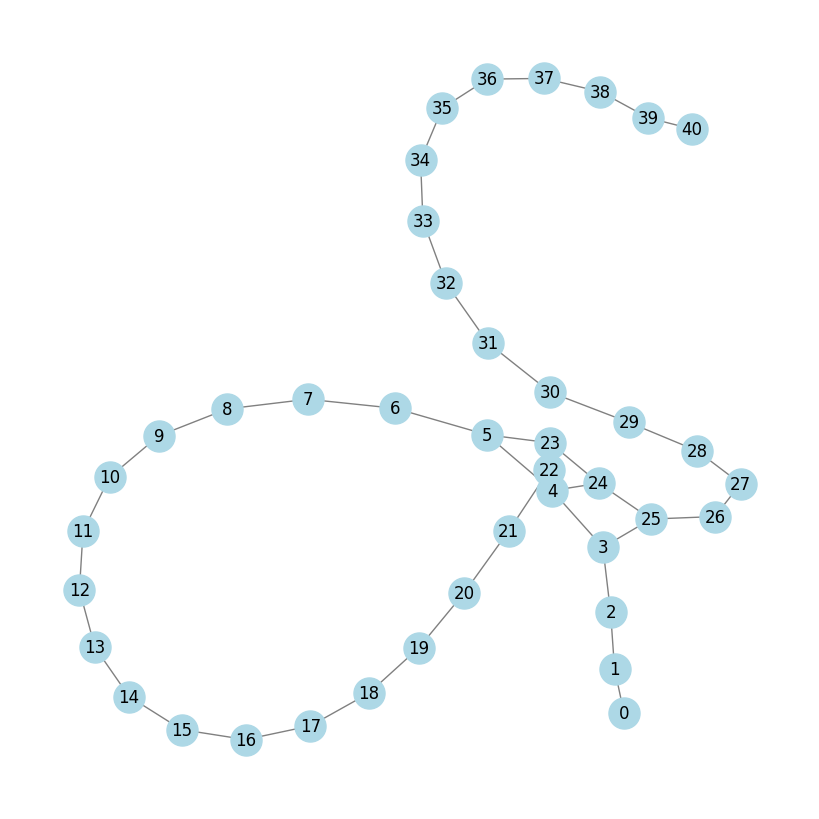

In [76]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Assume 'data' is your PyTorch Geometric Data object
# e.g., data = Data(x=node_features, edge_index=edge_indices)

# Convert to a networkx graph
G = to_networkx(data, to_undirected=True)

# Draw the graph
plt.figure(figsize=(8, 8))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.show()


In [56]:
base_pair_edges

tensor([], size=(2, 0), dtype=torch.int64)

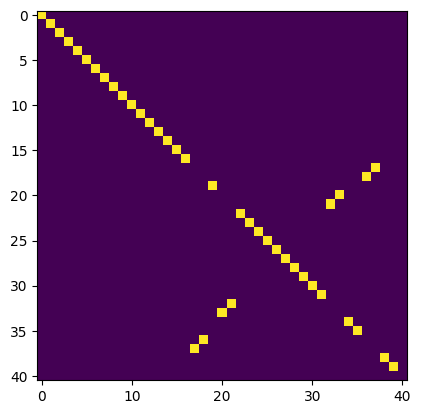

In [42]:
plt.imshow(structure_matrix[1942])


In [43]:
import numpy as np
import torch

def matrix_to_edge_index(matrix):
    # Find row and column indices where values are non-zero
    row, col = np.nonzero(matrix)

    # Create edge index tensor
    edge_index = torch.tensor(np.array([row, col]), dtype=torch.long)
    return edge_index

# Example usage for the first matrix
first_matrix = structure_matrix[1942]
edge_index = matrix_to_edge_index(first_matrix)

print(edge_index)  # Edge index tensor for the first graph



tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 37,
         36, 19, 33, 32, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 21, 20, 34, 35,
         18, 17, 38, 39]])


In [24]:
structure_matrix[0].shape

(41, 41)

In [13]:
import scipy.sparse as sp

sparse_matrix  = sp.csr_matrix(structure_matrix[0])

In [19]:
print(sparse_matrix)

  (0, 0)	1
  (1, 1)	1
  (2, 2)	1
  (3, 3)	1
  (4, 4)	1
  (5, 5)	1
  (6, 6)	1
  (7, 7)	1
  (8, 8)	1
  (9, 9)	1
  (10, 10)	1
  (11, 11)	1
  (12, 12)	1
  (13, 13)	1
  (14, 14)	1
  (15, 15)	1
  (16, 16)	1
  (17, 17)	1
  (18, 18)	1
  (19, 19)	1
  (20, 20)	1
  (21, 21)	1
  (22, 22)	1
  (23, 23)	1
  (24, 24)	1
  (25, 25)	1
  (26, 26)	1
  (27, 27)	1
  (28, 28)	1
  (29, 29)	1
  (30, 30)	1
  (31, 31)	1
  (32, 32)	1
  (33, 33)	1
  (34, 34)	1
  (35, 35)	1
  (36, 36)	1
  (37, 37)	1
  (38, 38)	1
  (39, 39)	1


In [11]:
structure_matrix[0]

(513695, 41, 41)